In [17]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [18]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def data_loader(data_dir='./datasets', batch_size=64, random_seed=0, valid_size=0.1, shuffle=True):
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # create training and validation datasets
    datasets_dict = {
        'train': datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform),
        'val': datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform)  
    }

    # create training and validation dataloaders
    loader = {
        'train': DataLoader(datasets_dict['train'], batch_size=batch_size, shuffle=shuffle),
        'val': DataLoader(datasets_dict['val'], batch_size=batch_size, shuffle=shuffle)
    }

    return loader['train'], loader['val']

# load data
train_loader, val_loader = data_loader()

Files already downloaded and verified
Files already downloaded and verified


In [19]:
print(train_loader.dataset)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./datasets
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [20]:
### downsample : change the size of the input image
### out_channels = the number of fillters in the convolution
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()  # Call constructor of nn.Module
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
        )
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x) # x -> conv1 -> out
        out = self.conv2(out) # out -> conv2 -> out is F(x) on the paper
        if self.downsample:
            residual = self.downsample(x) # adjust the size of the input x (residual)
        out += residual # F(x) + x
        out = self.relu(out)
        return out

![resnet34 architecture](../imgs/shows-the-adjusted-ResNet34-with-residual-modules-where-the-input-image-is-processed-by.png)

In [21]:
### build ResNet34

class ResNet34(nn.Module):
    # layers = [3, 4, 6, 3]: number of blocks in the layer 
    def __init__(self, block, layers, num_classes=10):
        super(ResNet34, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride=2)
        self.layer1 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride=2) 
        self.layer3 = self._make_layer(block, 512, layers[3], stride=2)
        # self.avgpool = nn.AvgPool2d(7,stride=1)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Thay vì AvgPool2d cố định

        self.fc = nn.Linear(512, num_classes)
    
    # inplanes = input channels, 
    # planes = output channels, 
    # blocks = number of blocks in the layer 
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1) # flatten the tensor to 2d: n, c, h, w -> n, c*h*w
        x = self.fc(x)
        return x

In [22]:
num_classes = 10
# num_epochs = 20
num_epochs = 5
batch_size = 16
learning_rate = 0.01
model = ResNet34(ResidualBlock, [3, 4, 6, 3]).to(device)
#Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.001, momentum = 0.9)  
#Train the model
total_step = len(train_loader)

In [23]:

### train the model 
def train_model(model, train_loader, val_loader, batch_size, num_epochs, criterion, optimizer):
    train_loss_history = []
    for epoch in range(num_epochs):
        # train phase
        train_loss = 0.0
        for inputs, labels in train_loader:
            # move tensors to GPU if CUDA is available
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss_history.append(train_loss/len(train_loader))
           
        # val phase
        correct = 0
        preds_list = []
        labels_list = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                preds_list += preds.tolist()
                labels_list += labels.tolist()
                c = (preds == labels).squeeze()
                correct += c.sum()
            
        if (epoch) % 1 == 0:
            print('Epoch: {}, Training loss: {}, Val accuracy: {}'.format(
                epoch,
                train_loss/len(train_loader),
                correct/len(val_loader)
                )
            )
        # Print classification report for validation set
        print("Classification Report for Epoch {}:".format(epoch))
        print(classification_report(labels_list, preds_list))
    
    plt.figure()     
    plt.plot(train_loss_history, label='training loss history')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

Epoch: 0, Training loss: 1.517171057288909, Val accuracy: 37.72611618041992
Classification Report for Epoch 0:
              precision    recall  f1-score   support

           0       0.64      0.61      0.62      1000
           1       0.77      0.77      0.77      1000
           2       0.44      0.57      0.49      1000
           3       0.38      0.45      0.41      1000
           4       0.54      0.39      0.45      1000
           5       0.49      0.53      0.51      1000
           6       0.78      0.56      0.65      1000
           7       0.66      0.66      0.66      1000
           8       0.74      0.65      0.69      1000
           9       0.65      0.75      0.69      1000

    accuracy                           0.59     10000
   macro avg       0.61      0.59      0.59     10000
weighted avg       0.61      0.59      0.59     10000

Epoch: 1, Training loss: 0.9796817472676183, Val accuracy: 43.261146545410156
Classification Report for Epoch 1:
              pre

AttributeError: Line2D.set() got an unexpected keyword argument 'labels'

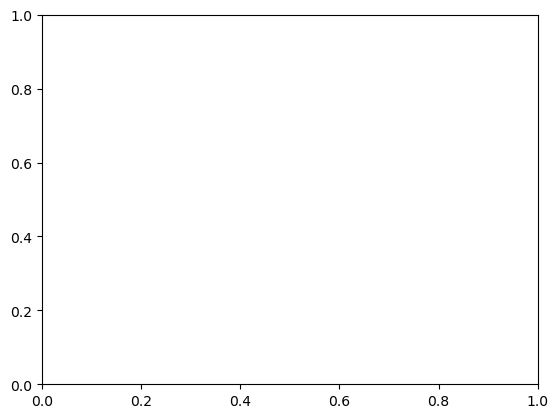

In [24]:
train_model(model, train_loader, val_loader, batch_size, num_epochs, criterion, optimizer)  